In [1]:
cd ..

C:\Users\Sommer Lab\Documents\Analysis Code


In [2]:
from ImageAnalysis import ImageAnalysisCode
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import pandas as pd
import os

In [3]:
####################################
#Set the date and the folder name
####################################
data_path =r"D:\Dropbox (Lehigh University)\Sommer Lab Shared\Data"
date = '3/7/2024'
data_folder = [
    r'/Andor/ODT 1900 Misalign_1',
    ]
Basler_folder = 'Basler\ODT 1900 Misalign_1'

In [4]:
####################################
#Parameter Setting
####################################
repetition = 1 #The number of identical runs to be averaged.
subtract_burntin = 0
examNum = None #The number of runs to exam.
examFrom = None #Set to None if you want to check the last several runs. 
plotPWindow = 5
intermediatePlot = True
uniformscale = 0
plt.rcParams.update({'font.size': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

variablesToDisplay = [
                    # 'Coil_medB', 
                       'ODT Misalign', 
                       'ODT Position',
                      'ZSBiasCurrent',
                      'VerticalBiasCurrent',
                       'CamBiasCurrent'
                      ]
showTimestamp = False
# variablesToDisplay=None
textY = 1
textVA = 'bottom'

variableFilterList = None
variableFilterList = [
    # 'wait==50', 
    ] # NO SPACE around the operator!

pictureToHide = None
# pictureToHide = [0,1,2,3] # list(range(0,10,2))

subtract_bg = 1
signal_feature = 'wide' 
signal_width = 10 #The narrower the signal, the bigger the number.
fitbgDeg = 5
angle_deg= 0.5 #rotates ccw

rowstart = 10
rowend = -10
columnstart = 10
columnend = -10

# rowstart = 660
# rowstart = 500
# rowend = -10
# columnstart = 600
# columnend = -200

# columnstart = 800
# columnend = 1200

# rowstart =750 #ODT 2675
# rowend = 830
# # rowstart =616 #ODT1675
# # rowend = 651
rowstart =970 #ODT19001
rowend = 1070
# # rowstart = 800 #ODT990
# # rowend = 835

# rowstart = 888 #ODT700
# rowend = 923
# rowstart = 1078 #ODT50
# rowend = 1113

# rowstart = 443 #ODT3800
# rowend = 478

rowstart -= 150
rowend += 150

####################################
####################################
dataLocation = ImageAnalysisCode.GetDataLocation(date, DataPath=data_path)
data_folder = [ dataLocation + f for f in data_folder ]
variableLog_folder = dataLocation + r'/Variable Logs'
examFrom, examUntil = ImageAnalysisCode.GetExamRange(examNum, examFrom, repetition)

picturesPerIteration = 4 if subtract_burntin else 3

params = ImageAnalysisCode.ExperimentParams(date, t_exp = 10e-6, picturesPerIteration= picturesPerIteration, cam_type = "zyla")

	New side imaging


In [5]:
images_array = None

for ff in data_folder:
    if images_array is None:
        images_array, fileTime = ImageAnalysisCode.LoadSpooledSeries(params = params, data_folder = ff, 
                                                                   return_fileTime=1, examFrom=examFrom, examUntil=examUntil)
    else:
        _images_array, _fileTime = ImageAnalysisCode.LoadSpooledSeries(params = params, data_folder = ff, 
                                                                       return_fileTime=1)
        images_array = np.concatenate([images_array, _images_array], axis=0)
        fileTime = fileTime + _fileTime

# images_array = images_array[examFrom: examUntil]
# fileTime = fileTime[examFrom: examUntil]

variableLog = ImageAnalysisCode.LoadVariableLog(variableLog_folder)
logTime = ImageAnalysisCode.Filetime2Logtime(fileTime, variableLog)
    
if variableFilterList is not None and variableLog is not None:    
    filteredList = ImageAnalysisCode.VariableFilter(logTime, variableLog, variableFilterList)
    images_array = np.delete(images_array, filteredList, 0)
    logTime = np.delete(logTime, filteredList, 0)

if pictureToHide is not None:
    images_array = np.delete(images_array, pictureToHide, 0)
    if logTime is not None:
        logTime = np.delete(logTime, pictureToHide, 0)

Number_of_atoms, N_abs, ratio_array, columnDensities, deltaX, deltaY = ImageAnalysisCode.absImagingSimple(images_array, 
                firstFrame=0, correctionFactorInput=1.0,  
                subtract_burntin=subtract_burntin, preventNAN_and_INF=True)
rotatedCD = rotate(columnDensities, angle_deg, axes=(1,2), reshape = False)[:, rowstart:rowend, columnstart:columnend]

dx = params.camera.pixelsize_microns/params.magnification
YcolumnDensities = rotatedCD.sum(axis=2) * dx / 1e6**2

popts = []
for ydata in YcolumnDensities:    
    popts.append( ImageAnalysisCode.fitMultiGaussian(ydata, dx=dx,
                                   subtract_bg=1, signal_feature='wide', 
                                   amp=1, width=3, denoise=0)[0] )
    
# XcolumnDensities = rotatedCD.sum(axis=1) * dx / 1e6**2
# poptsX = []
# for xdata in XcolumnDensities:
#     poptx,_ = ImageAnalysisCode.fitSingleGaussian(xdata, dx=dx,
#                                                   subtract_bg=1, signal_feature='wide')
#     poptsX.append(poptx)

results = ImageAnalysisCode.AnalyseFittingResults(popts, logTime=logTime)
if variableLog is not None:
    results = results.join(variableLog.loc[logTime])
# results.to_csv('0305.csv')

In [6]:
# %%
# Load the Basler pictures
data_folder_Basler = os.path.join(dataLocation, Basler_folder)
files = os.listdir(data_folder_Basler)
files.sort()
fileNo = len(files)

imgs_Basler = []
for file in files:
    path = os.path.join(data_folder_Basler, file)
    imgs_Basler.append( plt.imread(path)[...,0] )
imgs_Basler = np.array(imgs_Basler)

# Fit 1-D picture
imgs_oneD = imgs_Basler.sum(axis=1)
popt_Basler=[]
for ii in imgs_oneD:
    popt = ImageAnalysisCode.fitSingleGaussian(ii, signal_feature='narrow')
    popt_Basler.append(popt)

In [7]:
# Extract the position of the light and conbime it with the data from Zyla
center_Basler = [ii[1] for ii in popt_Basler]
dfjoin = results[['ODT_Misalign', 'Ycenter', 'Ywidth', 'YatomNumber']].copy()
dfjoin['center_Basler'] = center_Basler

========================

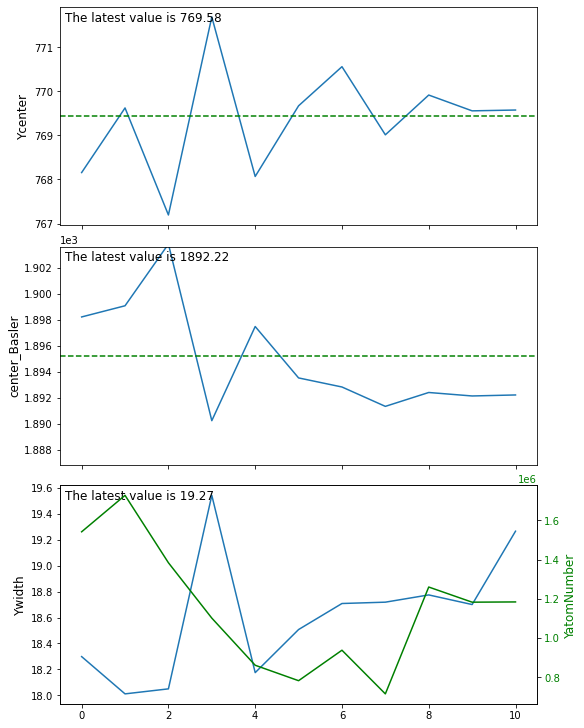

In [21]:
odtAlign(dfjoin, 769.44, 1895.24)

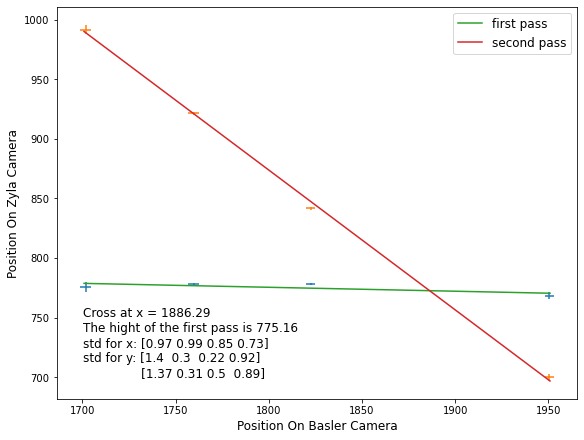

In [11]:
odtMisalign(dfjoin)

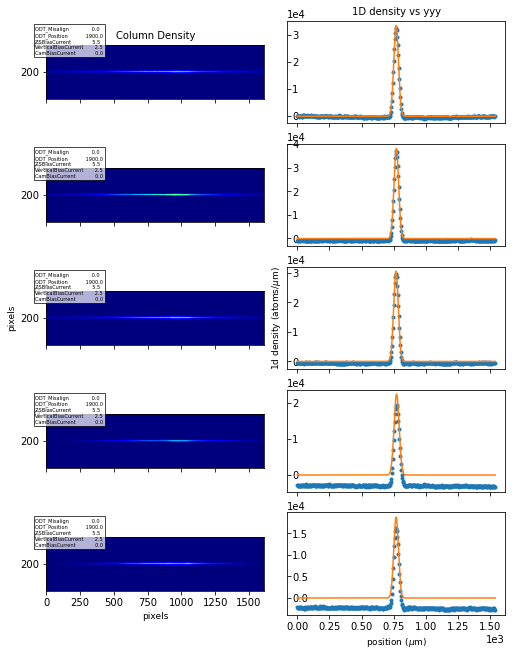

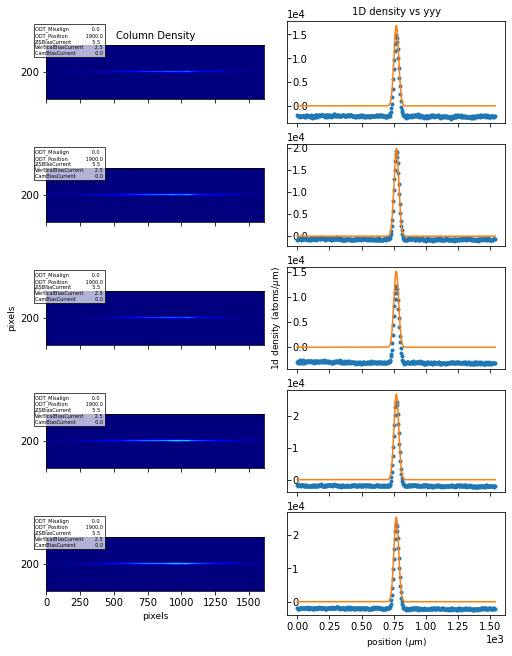

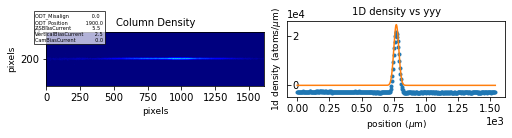

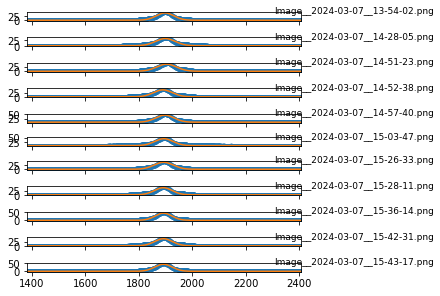

In [134]:
if intermediatePlot:
    # ImageAnalysisCode.ShowImagesTranspose(images_array, uniformscale=False)
    ImageAnalysisCode.plotImgAndFitResult(rotatedCD, popts, dx=dx, plotPWindow=plotPWindow,
                                      variablesToDisplay = variablesToDisplay,
                                      variableLog=variableLog, logTime=logTime,
                                      textLocationY=0.8)

    xx = np.arange(len(imgs_oneD[0]))
    fig, axes = plt.subplots(fileNo, 1, sharex=True, layout='constrained')
    for ii in range(fileNo):        
        axes[ii].plot(imgs_oneD[ii], '.')
        axes[ii].plot(xx, ImageAnalysisCode.Gaussian(xx, *popt_Basler[ii]))
        axes[ii].text(0.9,0.8, files[ii], transform=axes[ii].transAxes)

    c, w = np.array(popt_Basler).mean(axis=0)[1:-1]
    axes[-1].set(xlim=[c-15*w, c+15*w])